In [60]:
!pip install transformers==4.28.0
import transformers
import seaborn as sns

In [61]:
#importing the necessary libraries
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt


from torch.utils.data import TensorDataset

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from transformers import BertForSequenceClassification


In [62]:
print(torch.cuda.is_available())

True


In [63]:
from google.colab import drive
drive.mount('/content/drive')

파일ID = '19xN5gQxmloJ6O9HRlVzsqVcXhUmCZNrD'
파일저장이름 = 'mbti_1.csv'

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={파일ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={파일ID}" -O {파일저장이름} && rm -rf ~/cookies.txt

print(파일저장이름+"을 정상적으로 가져왔습니다.")

import pandas as pd
data = pd.read_csv(파일저장이름, sep='\t')

#importing the dataset into a DataFrame
df = pd.read_csv('mbti_1.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2023-11-25 01:42:33--  https://docs.google.com/uc?export=download&confirm=&id=19xN5gQxmloJ6O9HRlVzsqVcXhUmCZNrD
Resolving docs.google.com (docs.google.com)... 74.125.135.139, 74.125.135.113, 74.125.135.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rh62s9278h2fkich3obq45e2vtn7h9pb/1700876550000/17320300888472664624/*/19xN5gQxmloJ6O9HRlVzsqVcXhUmCZNrD?e=download&uuid=ea57423a-50dd-4e3b-b88b-6cafcf34620b [following]
--2023-11-25 01:42:41--  https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rh62s9278h2fkich3obq45e2vtn7h9pb/1700876550000/17320300888472664624/*/19xN5gQxmloJ6O9HRlVzsqVcXhUmCZNrD?e=download&uuid=ea57423a-50dd-

In [64]:
#showing the first 5 rows of the dataset
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [65]:
#showing dataset infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [66]:
#showing the posts of the first user in the dataset
df.posts.values[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [67]:
#showing the number of users per personality type
df.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [68]:
#visualizing the number of users per personality type using a histogram
# plt.figure(figsize=(20,10))
# sns.countplot(df.type)
# plt.xlabel('Types count');

In [69]:
#removing URLs and punctuation from dataset
for index in df.index.values:
  df.posts.iloc[index] = ' '.join(df.posts.iloc[index].split('|||'))
  df.posts.iloc[index] = re.sub(r"http\S+","",df.posts.iloc[index])
  df.posts.iloc[index] = re.sub(r"[-/@.?!_,:;()|0-9]","",df.posts.iloc[index])
  df.posts.iloc[index] = ' '.join(df.posts.iloc[index].split('  '))
df.head(10)

"""
saving the clean dataset into a csv file
df.to_csv('mbti_clean_dataset.csv',index=False)
"""

"\nsaving the clean dataset into a csv file\ndf.to_csv('mbti_clean_dataset.csv',index=False)\n"

In [70]:
#identifying the different classes of users in the dataset
labels = df.type.unique()
labels

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [71]:
#mapping personality types with their numberical representation
labels = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
labels_ids = {
    'ISTJ': 0, 'ISFJ': 1, 'INFJ': 2, 'INTJ': 3,
    'ISTP': 4, 'ISFP': 5, 'INFP': 6, 'INTP': 7,
    'ESTP': 8, 'ESFP': 9, 'ENFP': 10, 'ENTP': 11,
    'ESTJ': 12, 'ESFJ': 13, 'ENFJ': 14, 'ENTJ': 15
}

In [72]:
#replacing each personality type with its numerical representation
df['label'] = df.type.replace(labels_ids)
df.head(10)

,type,posts,label
0,INFJ,' enfp and intj moments sportscenter not top ...,2
1,ENTP,'I'm finding the lack of me in these posts ver...,11
2,INTP,'Good one Of course to which I say I know th...,7
3,INTJ,'Dear INTP I enjoyed our conversation the oth...,3
4,ENTJ,'You're fired That's another silly misconcepti...,15
5,INTJ,' Science is not perfect No scientist claims t...,3
6,INFJ,'No I can't draw on my own nails haha Those we...,2
7,INTJ,'I tend to build up a collection of things on ...,3
8,INFJ,I'm not sure that's a good question The distin...,2
9,INTP,' I'm in this position where I have to actuall...,7


In [73]:
#Splitting the dataset into training (85% of the data) and test (15% of the data) sets
x_train, x_test, y_train, y_test = train_test_split(df.index.values, df.label.values, test_size=0.15, random_state=17, stratify=df.label.values)

In [74]:
#creating a new column "data_type"
df['data_type'] = ['not_set']*df.shape[0]

In [75]:
#identifying the rows belonging to both training and test sets
df.loc[x_train,'data_type'] = 'train'
df.loc[x_test,'data_type'] = 'test'

In [76]:
df.head(10)

,type,posts,label,data_type
0,INFJ,' enfp and intj moments sportscenter not top ...,2,train
1,ENTP,'I'm finding the lack of me in these posts ver...,11,train
2,INTP,'Good one Of course to which I say I know th...,7,train
3,INTJ,'Dear INTP I enjoyed our conversation the oth...,3,train
4,ENTJ,'You're fired That's another silly misconcepti...,15,train
5,INTJ,' Science is not perfect No scientist claims t...,3,train
6,INFJ,'No I can't draw on my own nails haha Those we...,2,train
7,INTJ,'I tend to build up a collection of things on ...,3,train
8,INFJ,I'm not sure that's a good question The distin...,2,train
9,INTP,' I'm in this position where I have to actuall...,7,train


In [77]:
#showing the amount of data reserved for training and test per personality type
df.groupby(['type','label','data_type']).count()

posts
type label data_type       
ENFJ 14    test          28
           train        162
ENFP 10    test         101
           train        574
ENTJ 15    test          35
           train        196
ENTP 11    test         103
           train        582
ESFJ 13    test           6
           train         36
ESFP 9     test           7
           train         41
ESTJ 12    test           6
           train         33
ESTP 8     test          13
           train         76
INFJ 2     test         221
           train       1249
INFP 6     test         275
           train       1557
INTJ 3     test         164
           train        927
INTP 7     test         196
           train       1108
ISFJ 1     test          25
           train        141
ISFP 5     test          41
           train        230
ISTJ 0     test          31
           train        174
ISTP 4     test          50
           train        287

In [78]:
#creating a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

In [79]:
#encoding the data using our tokenizer
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].posts.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].posts.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [80]:
#showing an example of data tokenized and encoded by BERT tokenizer
encoded_data_test

{'input_ids': tensor([[  101,  1005,  2115,  ...,  2735,  2032,   102],
        [  101,  1005,  2008,  ...,  1055,  3267,   102],
        [  101,  1005,  1045,  ...,  2022,  4699,   102],
        ...,
        [  101,  1005,  1045,  ..., 10047,  5457,   102],
        [  101,  1005,  2987,  ...,  2015,  8915,   102],
        [  101,  1005, 11814,  ...,  2514,  2066,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [81]:
#preparing inputs for BERT model
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

In [82]:
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values)

In [83]:
dataset_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
dataset_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)
len(dataset_train)

7373

In [84]:
#creating a BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(labels_ids),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob=0.3,
                                                      hidden_dropout_prob=0.3)
model



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [85]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [86]:
#Defining the batch size
batch_size = 16
#less for limited hardware ressources. Example : 4

In [87]:
#creating dataloader to load the data while training
dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_test = DataLoader(dataset_test,
                                   sampler=SequentialSampler(dataset_test),
                                   batch_size=batch_size)

In [88]:
from transformers import AdamW, get_linear_schedule_with_warmup

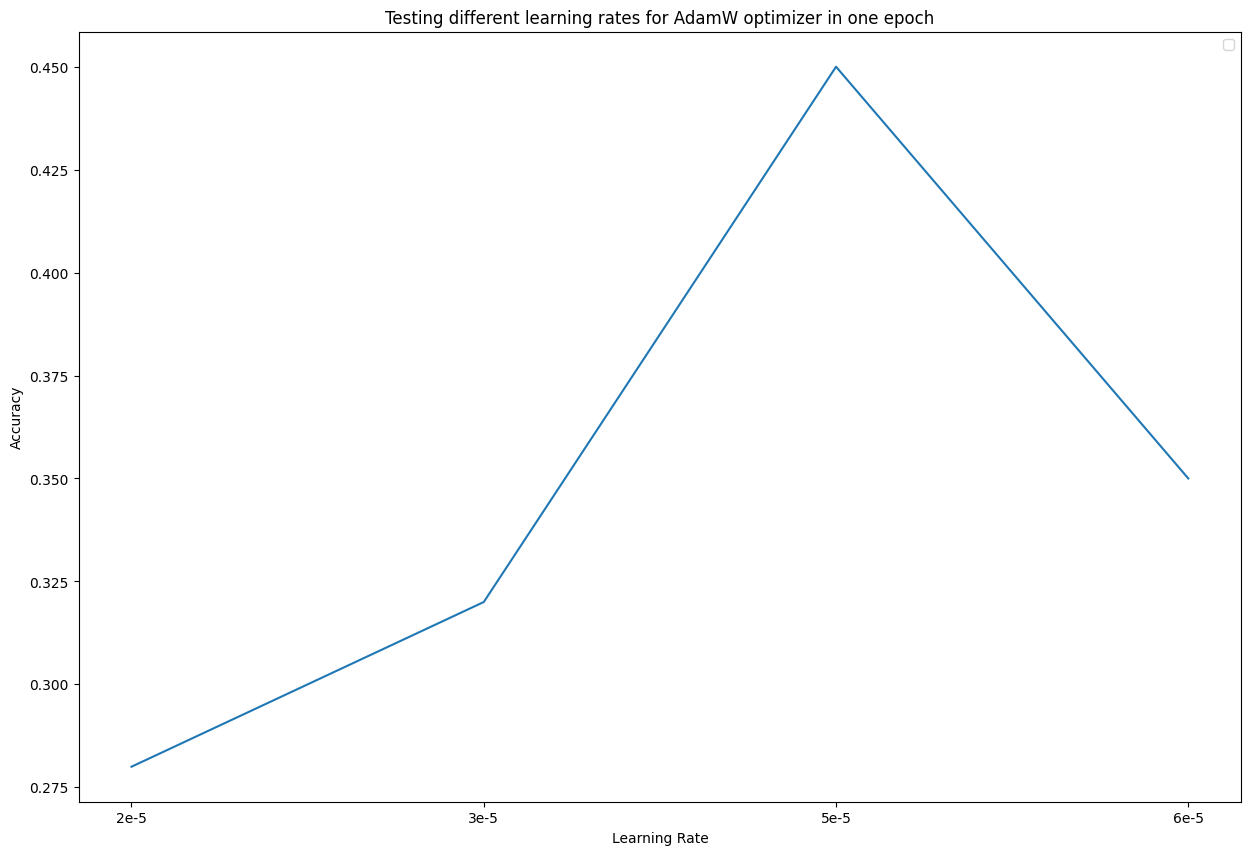

In [89]:
"""
Testing different learning rates for AdamW optimizer in one epoch
The following values of learning rates were tested on this code
Recommanded learning rate for BERT between 2e-5 and 5e-5
"""
learning_rate = ['2e-5','3e-5','5e-5','6e-5']
accuracy = [0.28,0.32,0.45,0.35]
plt.figure(figsize=(15,10))
plt.title('Testing different learning rates for AdamW optimizer in one epoch')
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')
plt.legend()
plt.plot(learning_rate,accuracy)

In [90]:
#creating an AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)
#recommanded epsilon : 1e-8

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [91]:
#Defining the number of epochs
epochs = 10

In [92]:
#creating a scheduler to update the learning rate while training
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0.1,
                                            num_training_steps=len(dataloader_train)*epochs)

In [93]:
import numpy as np

In [94]:
from sklearn.metrics import f1_score

In [95]:
#Defining the global accuracy function
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [96]:
#Defining the accuracy per class function
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in labels_ids.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
    return preds_flat, labels_flat

In [97]:
#Defining the device on which we're going to run the code
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

True
cuda


In [98]:
#Defining the evaluation function to get predictions and true types
def evaluate(dataloader_test):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_test:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_test)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [99]:
#Training

import random
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
f1_score_history = []
f1_score_train_history = []
train_loss_history = []
train_test_history = []

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_test)
    tr_loss, predictions_train, true_vals_train = evaluate(dataloader_train)
    val_f1 = f1_score_func(predictions, true_vals)
    tr_f1 = f1_score_func(predictions_train, true_vals_train)
    f1_score_history.append(val_f1)
    f1_score_train_history.append(tr_f1)
    tqdm.write(f'Test loss: {val_loss}')
    train_test_history.append(val_loss)
    tqdm.write(f'F1 Score test (Weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.3287822375328577
Test loss: 2.198493447245621
F1 Score test (Weighted): 0.14387913816817352


Epoch 2:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 2
Training loss: 2.1749516166989045
Test loss: 2.124314084285643
F1 Score test (Weighted): 0.23090207158548756


Epoch 3:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.966112781243314
Test loss: 1.938227505218692
F1 Score test (Weighted): 0.33094700763709844


Epoch 4:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.7597021591120325
Test loss: 1.9034385935562412
F1 Score test (Weighted): 0.33844879106581277


Epoch 5:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.621396726615517
Test loss: 1.9161599314794309
F1 Score test (Weighted): 0.3799576753417915


Epoch 6:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.4926000187040152
Test loss: 1.955226430078832
F1 Score test (Weighted): 0.42253410277491354


Epoch 7:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 7
Training loss: 1.3781209245421107
Test loss: 2.0111718563044945
F1 Score test (Weighted): 0.43790226894861883


Epoch 8:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 8
Training loss: 1.2658061622409655
Test loss: 2.056796488238544
F1 Score test (Weighted): 0.44445153454730185


Epoch 9:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 9
Training loss: 1.180886780426973
Test loss: 2.053364744273628
F1 Score test (Weighted): 0.44430780316164725


Epoch 10:   0%|          | 0/461 [00:00<?, ?it/s]


Epoch 10
Training loss: 1.1217621716785844
Test loss: 2.0855529351932245
F1 Score test (Weighted): 0.443311752118681


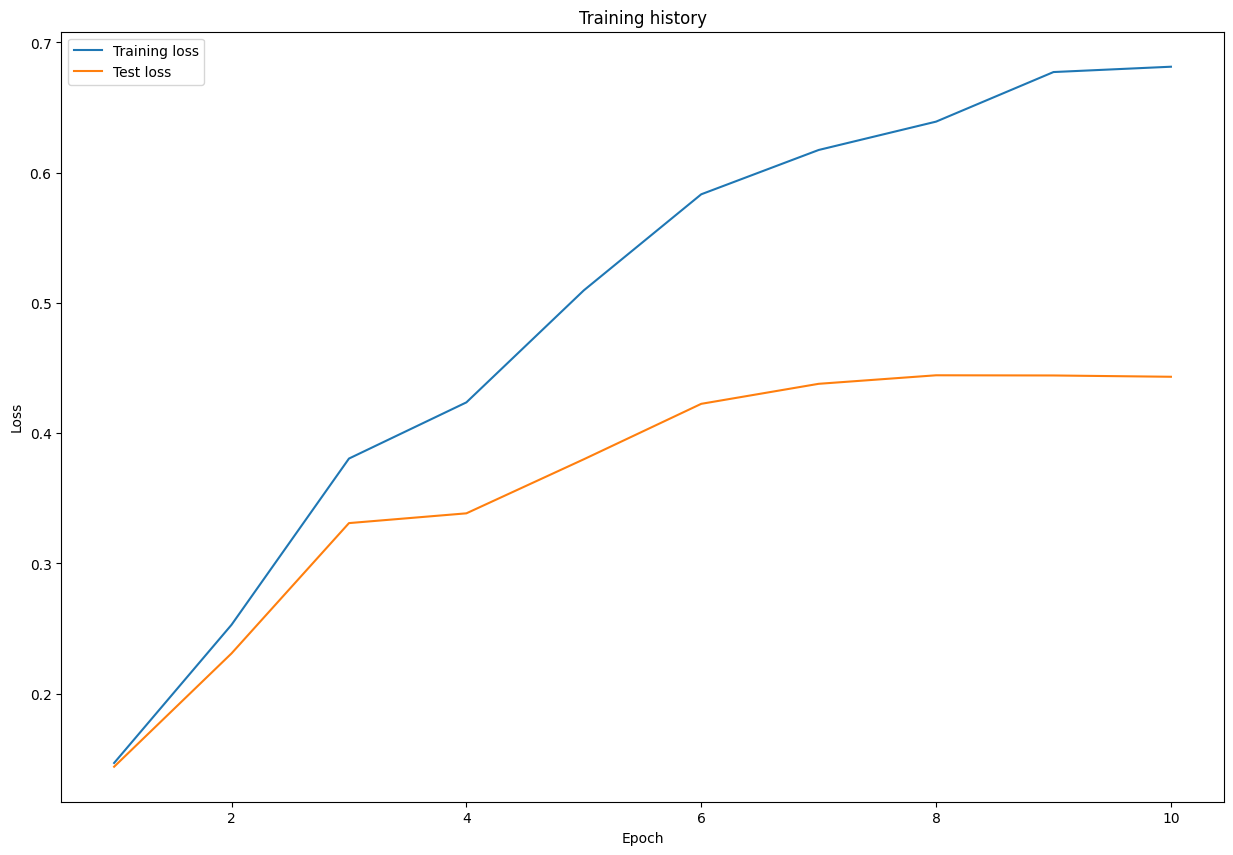

In [100]:
#Plotting the training and test accuracy per epoch

plt.figure(figsize=(15,10))
plt.plot(range(1,epochs+1),f1_score_train_history,label='Training loss')
plt.plot(range(1,epochs+1),f1_score_history,label='Test loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


In [101]:
#creating a BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(labels_ids),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      hidden_dropout_prob=0.3)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [102]:
#Loading the model we saved in a file
model.load_state_dict(torch.load('finetuned_BERT_epoch_4.model', map_location=torch.device('cuda')))

<All keys matched successfully>

In [103]:
#Getting the predictions and the types of the users in the test set
_, predictions, true_vals = evaluate(dataloader_test)

In [104]:
#Getting the accuracy per class of each personality type
y_preds, y_true = accuracy_per_class(predictions, true_vals)

Class: ISTJ
Accuracy: 3/31

Class: ISFJ
Accuracy: 1/25

Class: INFJ
Accuracy: 110/221

Class: INTJ
Accuracy: 79/164

Class: ISTP
Accuracy: 13/50

Class: ISFP
Accuracy: 0/41

Class: INFP
Accuracy: 182/275

Class: INTP
Accuracy: 10/196

Class: ESTP
Accuracy: 0/13

Class: ESFP
Accuracy: 0/7

Class: ENFP
Accuracy: 39/101

Class: ENTP
Accuracy: 48/103

Class: ESTJ
Accuracy: 0/6

Class: ESFJ
Accuracy: 0/6

Class: ENFJ
Accuracy: 3/28

Class: ENTJ
Accuracy: 6/35



              precision    recall  f1-score   support

        ISTJ       0.19      0.10      0.13        31
        ISFJ       0.50      0.04      0.07        25
        INFJ       0.42      0.50      0.46       221
        INTJ       0.29      0.48      0.36       164
        ISTP       0.25      0.26      0.25        50
        ISFP       1.00      0.00      0.00        41
        INFP       0.47      0.66      0.55       275
        INTP       0.20      0.05      0.08       196
        ESTP       1.00      0.00      0.00        13
        ESFP       1.00      0.00      0.00         7
        ENFP       0.34      0.39      0.36       101
        ENTP       0.45      0.47      0.46       103
        ESTJ       1.00      0.00      0.00         6
        ESFJ       1.00      0.00      0.00         6
        ENFJ       0.16      0.11      0.13        28
        ENTJ       0.29      0.17      0.21        35

    accuracy                           0.38      1302
   macro avg       0.53   

<ipython-input-105-8badd431bf55>:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_mat = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]


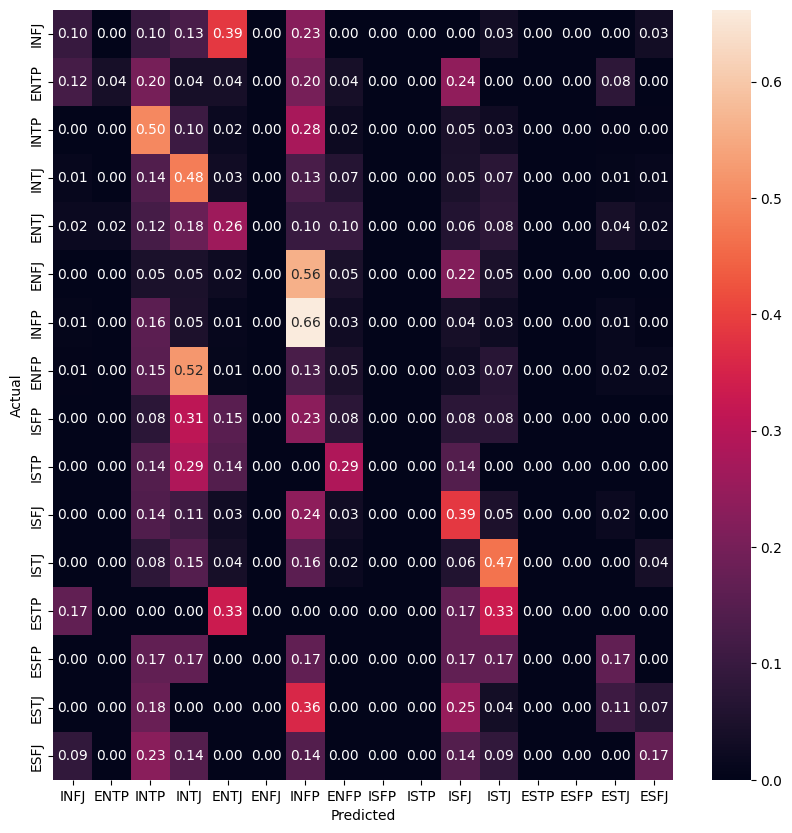

In [105]:
#Plotting the confusion matrix in order to identifiy the misclassified types
import seaborn as sns
from sklearn import metrics
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(20,10))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Type')
  plt.xlabel('Predicted Type');

# classification_report 계산
evaluation_report = metrics.classification_report(y_true, y_preds, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()), zero_division=1)

print(evaluation_report)
# evaluation_report = metrics.classification_report(true_vals, predictions, labels=labels2, target_names=labels2, zero_division=1)
# # Show the evaluation report.
# print(evaluation_report)

cm = metrics.confusion_matrix(y_true, y_preds)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
conf_mat = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [106]:
"""
In the next step, we're going to try to understand the reason why certain personality types are being misclassified.
We're gonna use INFP and INFJ personality types as an example.
We're going to identify the vocabulary used in commun between these two types and calculate its percentage
"""
infj = df[df.type=='INFJ'].posts.values

In [107]:
infp = df[df.type=='INFP'].posts.values

In [108]:
infj_tokens = []
for post in infj:
  tokens = tokenizer.tokenize(post)
  infj_tokens = infj_tokens + tokens
infj_tokens = list(set(infj_tokens))
len(infj_tokens)

20629

In [109]:
infp_tokens = []
for post in infp:
  tokens = tokenizer.tokenize(post)
  infp_tokens = infp_tokens + tokens
infp_tokens = list(set(infp_tokens))
len(infp_tokens)

21417

In [110]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [111]:
inter = intersection(infj_tokens,infp_tokens)

In [112]:
len(inter)/len(infp_tokens)*100

88.691226595695

In [113]:
len(inter)/len(infj_tokens)*100

92.07911192980755

The results obtained are realistic, since INFPs and INFJs share many personality traits according to psychologists.

In [114]:
#Identifying the missclassifications in each personaity trait
def translate(list1 , list2):
  lst=[]
  for x in list1:
    if x in list2:
      lst.append(0)
    else:
      lst.append(1)
  return(lst)
y_true_ie=translate(y_true,[0,6,3,2,10,8,11,9])
y_preds_ie=translate(y_preds,[0,6,3,2,10,8,11,9])

y_true_sn=translate(y_true,[15,13,14,12,10,8,11,9])
y_preds_sn=translate(y_preds,[15,13,14,12,10,8,11,9])

y_true_tf=translate(y_true,[4,1,14,12,3,2,11,9])
y_preds_tf=translate(y_preds,[4,1,14,12,3,2,11,9])

y_true_jp=translate(y_true,[5,4,15,14,0,3,10,11])
y_preds_jp=translate(y_preds,[5,4,15,14,0,3,10,11])

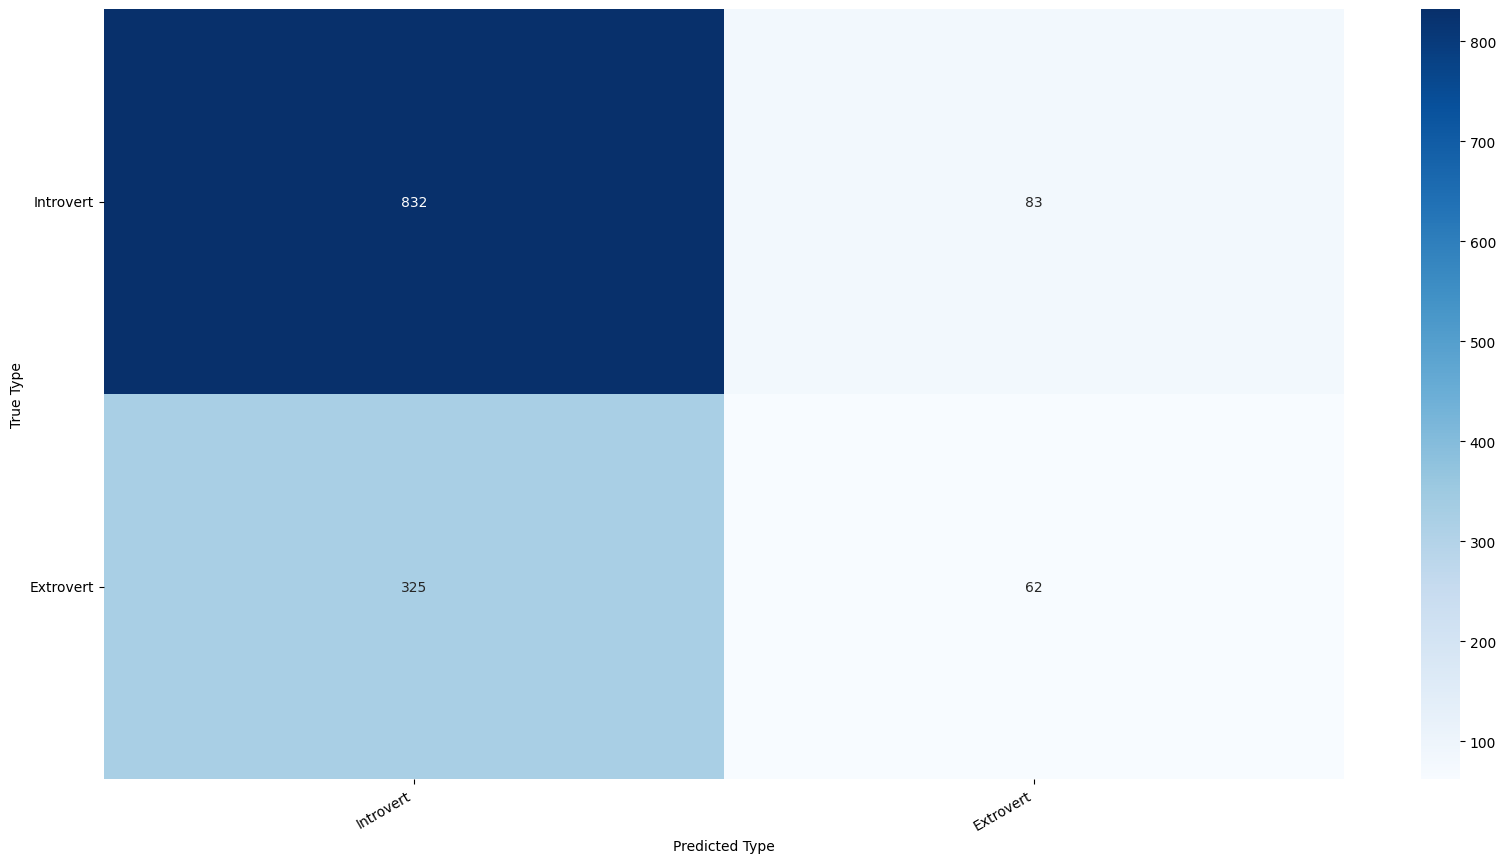

In [115]:
#Plotting the confusion matrix for Introverts vs Extroverts
cm = metrics.confusion_matrix(y_true_ie, y_preds_ie)
df_cm = pd.DataFrame(cm, index=['Introvert','Extrovert'], columns=['Introvert','Extrovert'])
show_confusion_matrix(df_cm)

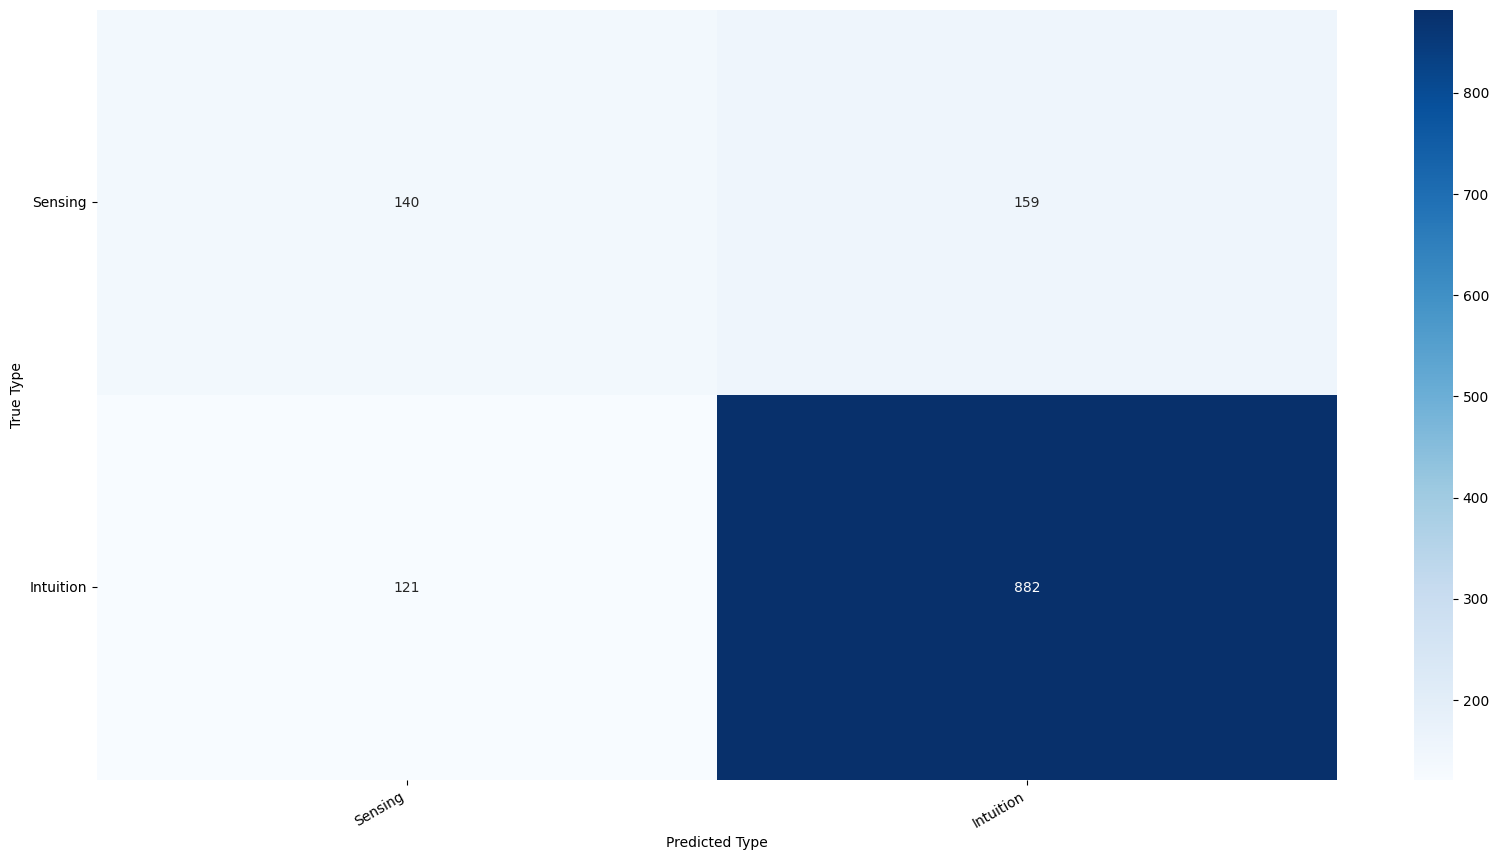

In [116]:
#Plotting the confusion matrix for Sensing vs Intuitive
cm = metrics.confusion_matrix(y_true_sn, y_preds_sn)
df_cm = pd.DataFrame(cm, index=['Sensing','Intuition'], columns=['Sensing','Intuition'])
show_confusion_matrix(df_cm)

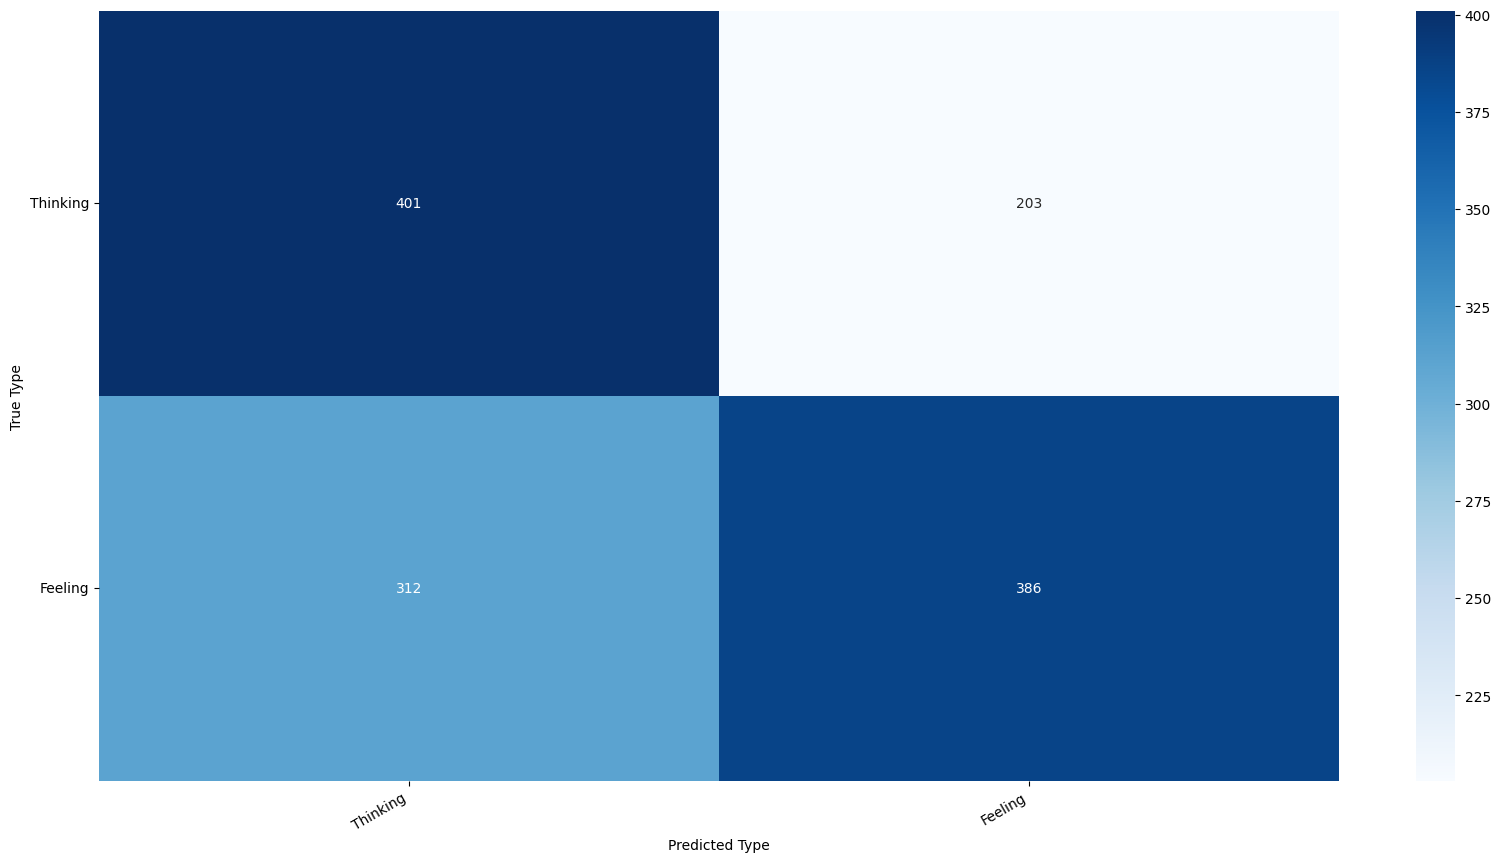

In [117]:
#Plotting the confusion matrix for Thinking vs Feeling
cm = metrics.confusion_matrix(y_true_tf, y_preds_tf)
df_cm = pd.DataFrame(cm, index=['Thinking','Feeling'], columns=['Thinking','Feeling'])
show_confusion_matrix(df_cm)

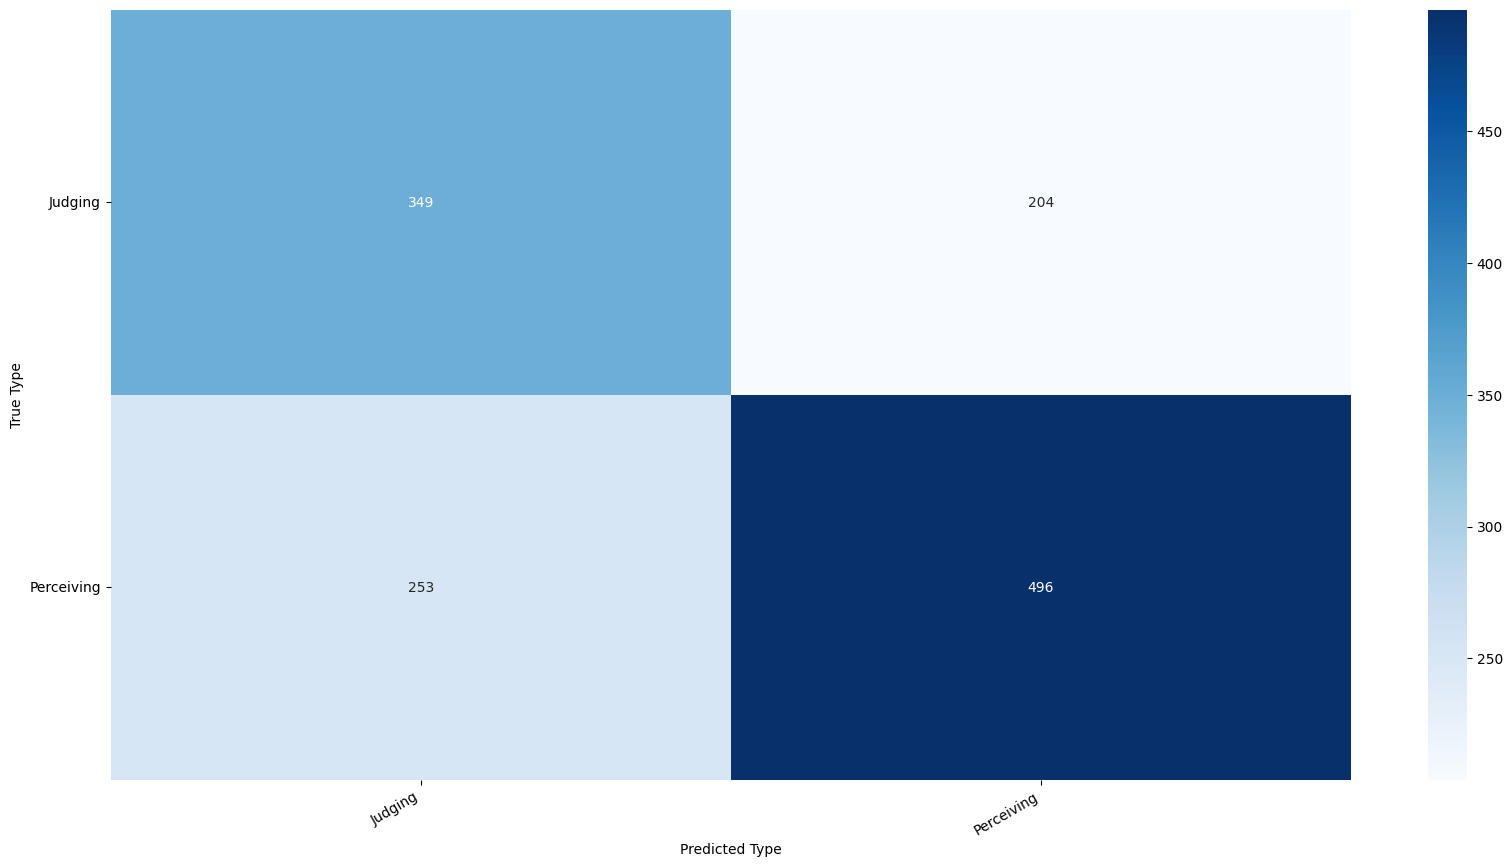

In [118]:
#Plotting the confusion matrix for Judging vs Perceiving
cm = metrics.confusion_matrix(y_true_jp, y_preds_jp)
df_cm = pd.DataFrame(cm, index=['Judging','Perceiving'], columns=['Judging','Perceiving'])
show_confusion_matrix(df_cm)
